<a href="https://colab.research.google.com/github/GreenOrange44/AIR/blob/main/HandsOn/MarkovDecisionProcess/ValueIterationQLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#####################################################################
#Program for Markov Decision Process and Q learning


import copy
from tqdm import tqdm
from helper import *


import numpy as np
import matplotlib.pyplot as plt


# see their meaning on google




### value  iteration


# value iteration algorithm
class ValueIteration():
    """
    Value Iteration
    - In the paper, the states are represented by 1-based indexing
    - In the code, we will be using 0-based indexing
    """


    def __init__(self, exp_info = {}):
        """Initialization method for the class"""


        # Defining the number of states & actions
        self.num_states  = 4
        self.num_actions = 2


        # Defining the rewards
        # The rewards are independent of the action
        self.rewards = np.array([-1, 0, 0, 1])


        # Defining the transition probabilities {p(s'|s, a)}
        temp = np.array([
            [0.5, 0, 0, 0.5],
            [0.5, 0.5, 0, 0],
            [0, 0.5, 0.5, 0],
            [0, 0, 0.5, 0.5]
        ]) # play with it change it and observe the change in graphs
        self.tran_probs = np.ones((2, 4, 4))
        self.tran_probs[0, :, :] = temp
        self.tran_probs[1, :, :] = temp.T


        # Defining a random generator
        self.rng = np.random.RandomState(exp_info.get("seed", 0))


        # Defining the experiment parameters
        self.delta     = exp_info.get("delta", 1e-2)
        self.max_iters = exp_info.get("max_iters", 100)
        self.discount  = exp_info.get("discount", 1)


        # Initializing the state values
        self.s_vals = np.zeros(self.num_states)


    def iterate(self):
        """Performs the iterations over the state space"""


        # Initializing some variables
        n = 0
        l_s_vals = []
        temp_delta = self.delta


        while temp_delta >= self.delta and n < self.max_iters:
            temp_delta = 0


            for s in range(self.num_states):
                max_val = 1e-5
                for a in range(self.num_actions):
                    # Calculating the value for a (S, A) pair
                    temp_val = 0
                    for s_prime in range(self.num_states):
                        temp_val += self.tran_probs[a, s, s_prime] * (
                            self.rewards[s] + self.discount * self.s_vals[s_prime]
                        )
                    max_val = max(max_val, temp_val)


                temp_delta = max(temp_delta, abs(max_val - self.s_vals[s]))
                self.s_vals[s] = max_val


            n += 1
            l_s_vals.append(copy.deepcopy(self.s_vals))


            ### DEBUG CODE
            # print(temp_delta, self.s_vals)


        return self.s_vals, np.array(l_s_vals)


Number of Iterations -> 17


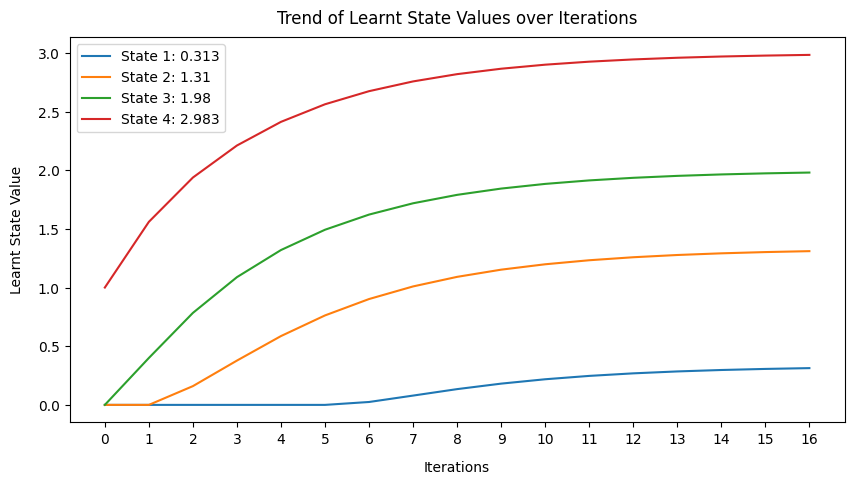

In [ ]:
# Plotting


# Plot the function
def plot_s_vals_1(l_s_vals):
    # Extracting the required information
    num_iters = len(l_s_vals)
    num_states = len(l_s_vals[0])


    plt.figure(figsize = (10, 5))


    # Plotting the State Values
    for s in range(num_states):
        plt.plot(range(num_iters), l_s_vals[ : , s], label = f"State {s + 1}: {np.round(l_s_vals[-1, s], 3)}")


    plt.xticks(range(0, num_iters, num_iters // 10))
    plt.title(f"Trend of Learnt State Values over Iterations", pad = 10)
    plt.xlabel("Iterations", labelpad = 10)
    plt.ylabel("Learnt State Value", labelpad = 10)
    plt.legend(loc = 'upper left')
    plt.show()




# feed the parameter and run value iteration algorithm
exp_info = {
    'delta': 1e-2,
    'max_iters': 100,
    'discount': 0.8
}


env = ValueIteration(exp_info)
s_vals, ValIter_s_vals = env.iterate()
num_iters = len(ValIter_s_vals)
#print(len(num_iters))
print(f"Number of Iterations -> {num_iters}")


# Plotting the State Values
plot_s_vals_1(ValIter_s_vals)



In [ ]:
##############################################################################


# Q Learning Algorithm


class QLearn():
    """
    Q-Learning
    - In the paper, the states are represented by 1-based indexing
    - In the code, we will be using 0-based indexing
    """


    def __init__(self, exp_info = {}):
        """Initialization method for the class"""


        # Defining the number of states & actions
        self.num_states  = 4
        self.num_actions = 2


        # Defining the rewards
        # The rewards are independent of the action
        self.rewards = np.array([-1, 0, 0, 1])


        # Defining the transition probabilities {p(s'|s, a)}
        temp = np.array([
            [0.5, 0, 0, 0.5],
            [0.5, 0.5, 0, 0],
            [0, 0.5, 0.5, 0],
            [0, 0, 0.5, 0.5]
        ])
        self.tran_probs = np.ones((2, 4, 4))
        self.tran_probs[0, :, :] = temp
        self.tran_probs[1, :, :] = temp.T


        # Defining a random generator
        self.rng = np.random.RandomState(exp_info.get("seed", 0))


        # Initializing the action values and the state
        self.q_vals = np.zeros((self.num_states, self.num_actions))
        self.cur_state = 0


        # Defining the experiment parameters
        self.step_size    = exp_info.get("step_size", 0.1)
        self.discount     = exp_info.get("discount", 1)
        self.delta        = exp_info.get("delta", 1e-2)
        self.eps          = exp_info.get("epsilon", 0.1)
        self.max_iters    = exp_info.get("max_iters", 100)
        self.warmup_iters = exp_info.get("warmup_iters", 10)


    def _step(self):
        """
        Returns a tuple: (S, A, R, S')
        - We will choose the action using an epsilon-greedy policy derived from q
        """


        temp = self.rng.rand()


        # Exploratory action
        if temp <= self.eps:
            chosen_action = self.rng.choice(self.num_actions)


        # Exploitary action
        else:
            cur_pi = np.argmax(self.q_vals, axis = -1)
            chosen_action = cur_pi[self.cur_state]


        reward = self.rewards[self.cur_state]
        next_state = self.rng.choice(self.num_states, p = self.tran_probs[chosen_action, self.cur_state, :])
        prev_state = copy.copy(self.cur_state)
        self.cur_state = next_state


        return (prev_state, chosen_action, reward, next_state)




    def iterate(self):
        """Performs the iterations over the state space"""


        # Initialization of the required variables
        n = 0
        l_s_vals = []
        temp_delta = self.delta


        while n < self.max_iters and (n < self.warmup_iters or \
           (n >= self.warmup_iters and temp_delta >= self.delta)):


            # Taking a single step
            s, a, r, s_prime = self._step()


            # Computing the action value
            new_val = self.q_vals[s, a] + self.step_size * (
                self.rewards[s] + self.discount * np.max(self.q_vals[s_prime, :]) - \
                self.q_vals[s, a]
            )


            # Updating the delta, index and action value
            n += 1
            temp_delta = abs(new_val - self.q_vals[s, a])
            self.q_vals[s, a] = new_val


            if n % (self.max_iters // 100) == 0:
                s_vals = np.max(self.q_vals, axis = -1)
                l_s_vals.append(s_vals)




        return self.q_vals, np.array(l_s_vals), n






Number of Iterations -> 100000
Policy -> [0 1 1 0]


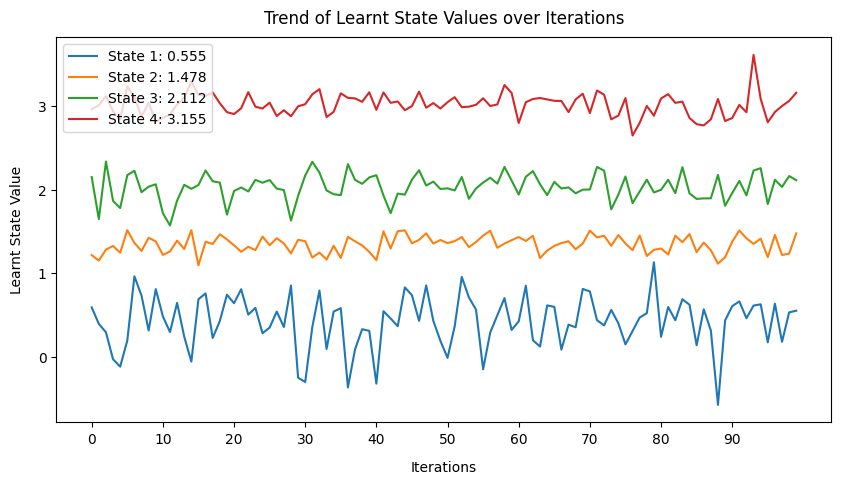

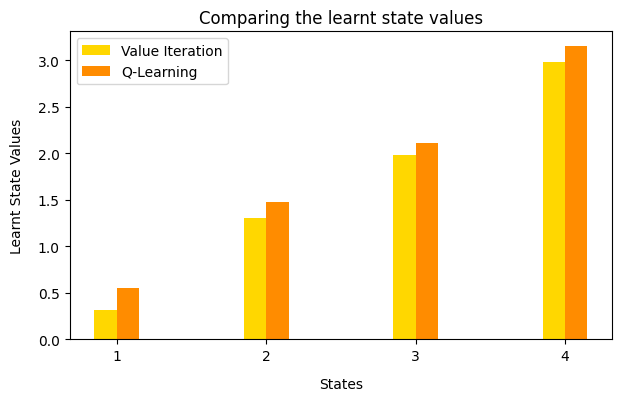

In [ ]:
def plot_s_vals_2(ValIter_s_vals, QLearn_s_vals, label1, label2):
    num_states = len(ValIter_s_vals[0])


    plt.figure(figsize = (7, 4))
    plt.bar(range(num_states), ValIter_s_vals[-1], width = -0.15, color = 'gold',
        align = 'edge', label = label1)
    plt.bar(range(num_states), QLearn_s_vals[-1], width = 0.15, color = 'darkorange',
        align = 'edge', label = label2)
    plt.xticks(range(num_states), range(1, num_states + 1))
    plt.title("Comparing the learnt state values")
    plt.xlabel("States", labelpad = 10)
    plt.ylabel("Learnt State Values", labelpad = 10)
    plt.legend()
    plt.show()




exp_info = {
    'delta': 1e-2,
    'max_iters': 1e5,
    'discount': 0.8,
    'epsilon': 0.3,
    'step_size': 0.1,
    'warmup_iters': 1e5,
}


env = QLearn(exp_info)
q_vals, QLearn_s_vals, num_iters = env.iterate()
pi = np.argmax(q_vals, axis = -1)
print(f"Number of Iterations -> {num_iters}")
print(f"Policy -> {pi}")


# Plotting the State Values
plot_s_vals_1(QLearn_s_vals)
plot_s_vals_2(ValIter_s_vals, QLearn_s_vals, "Value Iteration", "Q-Learning")




